In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import vel
import vel.notebook as nb
nb.reasonable_notbook_defaults()
torch.set_grad_enabled(False)  # We don't need autograd here
None

In [3]:
config = nb.load_config('examples-configs/autoencoders/mnist/mnist_cnn_vae.yaml', run_number=2, device='cpu')

In [4]:
model = config.load_trained_model()

In [5]:
model.summary()

MnistCnnVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): Flatten()
    (6): Linear(in_features=784, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=784, bias=True)
    (1): ReLU(inplace)
    (2): Reshape()
    (3): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU(inplace)
    (5): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU(inplace)
    (7): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Sigmoid()
  )
)
----------------------------------------------------------------------------------------------------
Number of model

In [6]:
data_source = config.provide('source')
train_dataset = data_source.train_dataset

In [7]:
def get_sample(idx):
    return train_dataset[idx][0]

In [8]:
def show_image(axis, sample):
    axis.imshow(train_dataset.denormalize(sample)[:, :, 0], cmap='gray')

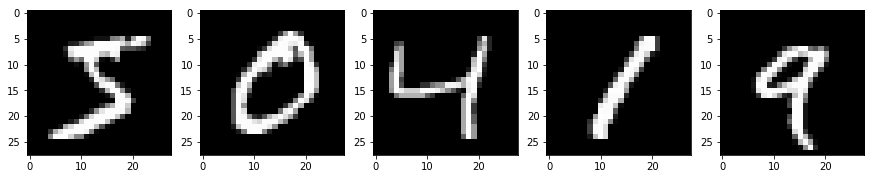

In [9]:
# Browse examples
fig, axes = plt.subplots(1, 5)

for index in range(5):
    show_image(axes[index], get_sample(index))

In [10]:
 model.encode(get_sample(0)[None])

tensor([[ 0.7010,  0.7096,  0.2029, -0.8527, -0.1471,  0.1670, -0.0375,  1.2047,
         -1.9497, -0.1735,  2.7477,  0.9634, -1.8239, -1.0749,  0.8230,  0.0965]])

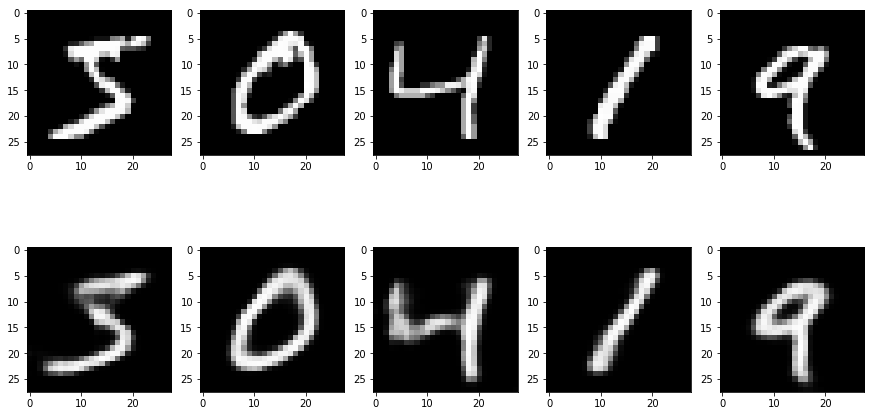

In [11]:
# Browse examples
fig, axes = plt.subplots(2, 5)

for index in range(5):
    sample = get_sample(index)
    decoded = model(sample[None])['decoded'][0].detach()
    show_image(axes[0, index], sample)
    show_image(axes[1, index], decoded)

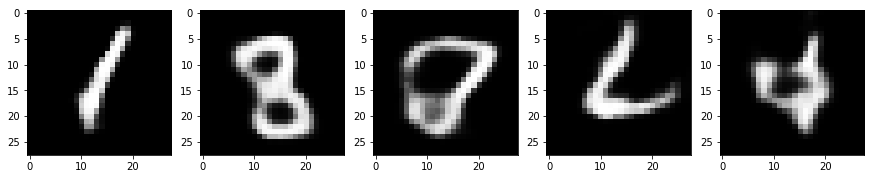

In [12]:
samples = torch.randn(5, model.representation_length)

fig, axes = plt.subplots(1, 5)

for index in range(5):
    decoded = model.decoder(samples[index][None])[0].detach()
    show_image(axes[index], decoded)

In [14]:
 model.encode(get_sample(0)[None])

tensor([[ 0.8606,  0.9047,  0.1575, -0.7448, -0.3117,  0.0745, -0.3145,  1.4116,
         -1.5365, -0.6043,  2.6963,  0.4136, -1.0794, -0.8664,  0.7766, -0.4429]])

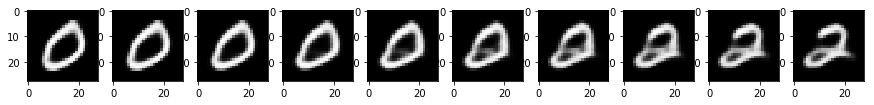

In [19]:
idx1 = 1
idx2 = 5

N = 10

encoding1 = model.encode(get_sample(idx1)[None])
encoding2 = model.encode(get_sample(idx2)[None])

fig, axes = plt.subplots(1, N)

for i in range(10):
    beta = float(i) / float(N - 1)
    alpha = 1.0 - beta
    
    combined =  model.decoder(encoding1 * alpha + encoding2 * beta)[0]
    
    show_image(axes[i], combined)